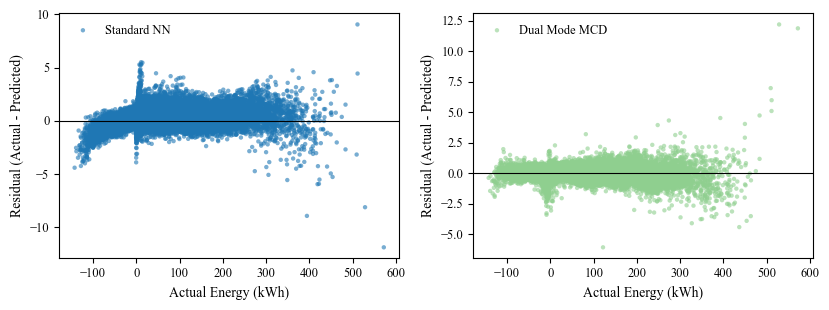

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 0.8,
})

df = pd.read_csv("comparison_results/residual_plot_data.csv")
T = "net_energy_kwh"

y = df[T].values
nn_res = df[f"{T}_standard_residual"].values
mcd_res = df[f"{T}_residual"].values

fig, axes = plt.subplots(1, 2, figsize=(8.4, 3.2), sharey=False)

axes[0].scatter(
    y, nn_res,
    s=10, alpha=0.6,
    color="#1f77b4",
    edgecolors="none",
    label="Standard NN"
)
axes[0].axhline(0, color="black", lw=0.8)
axes[0].set_xlabel("Actual Energy (kWh)")
axes[0].set_ylabel("Residual (Actual - Predicted)")
axes[0].legend(frameon=False, fontsize=9)
axes[0].grid(False)

axes[1].scatter(
    y, mcd_res,
    s=10, alpha=0.6,
    color="#8fcf8f",
    edgecolors="none",
    label="Dual Mode MCD"
)
axes[1].axhline(0, color="black", lw=0.8)
axes[1].set_xlabel("Actual Energy (kWh)")
axes[1].set_ylabel("Residual (Actual - Predicted)")
axes[1].legend(frameon=False, fontsize=9)
axes[1].grid(False)

plt.tight_layout()
plt.show()


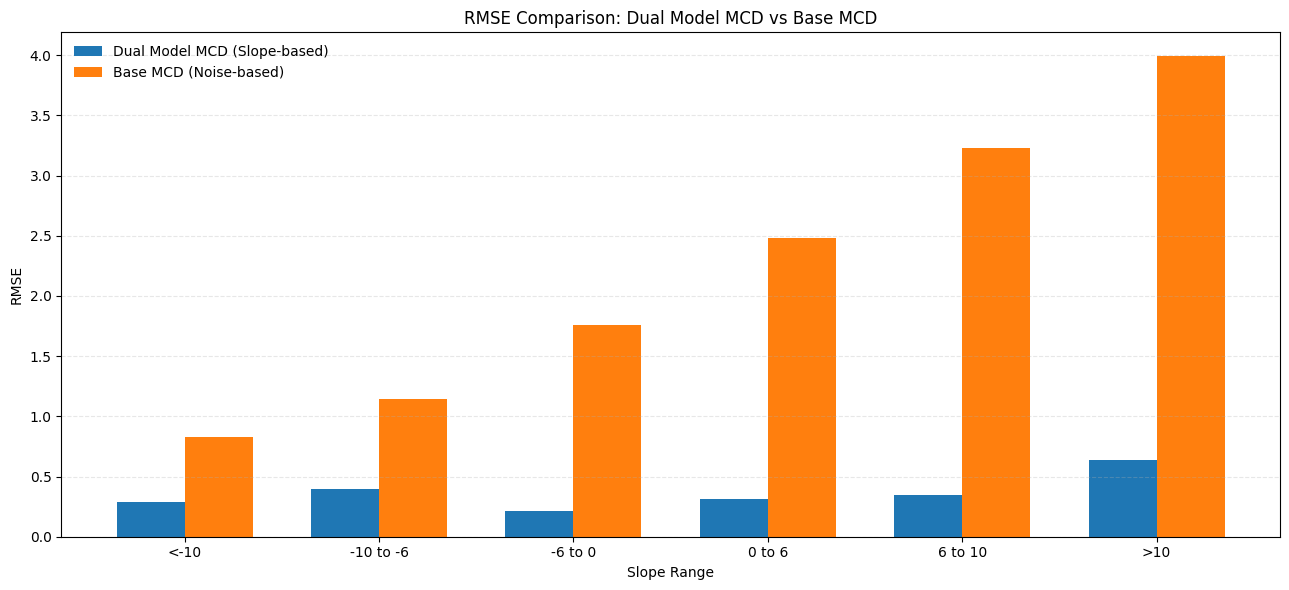

In [3]:
import matplotlib.pyplot as plt
import numpy as np

dual_categories = ['<-10', '-10 to -6', '-6 to 0', '0 to 6', '6 to 10', '>10']
dual_rmse = [0.2890, 0.3926, 0.2177, 0.3094, 0.3474, 0.6406]
base_rmse = [0.830, 1.14, 1.76, 2.48, 3.23, 3.99]

x = np.arange(len(dual_categories))
w = 0.35

plt.figure(figsize=(13, 6))
plt.bar(x - w/2, dual_rmse, w, label="Dual Model MCD (Slope-based)")
plt.bar(x + w/2, base_rmse, w, label="Base MCD (Noise-based)")

plt.xticks(x, dual_categories)
plt.xlabel("Slope Range")
plt.ylabel("RMSE")
plt.title("RMSE Comparison: Dual Model MCD vs Base MCD")
plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


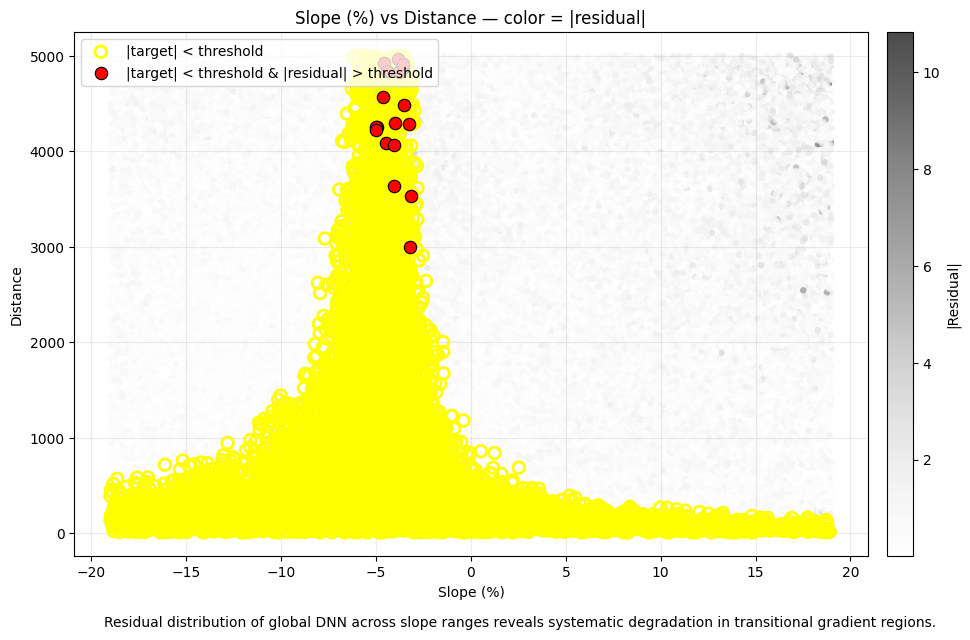

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("residual_csv/residual_scatter_distance.csv")

slope = df["slope_percent"]
x2 = df["distance"]
res = df["abs_residual"]
yellow = df["yellow_mask"].astype(bool)
red = df["red_mask"].astype(bool)

fig, ax = plt.subplots(figsize=(10.5, 6.2))

sc = ax.scatter(slope, x2, c=res, cmap="Greys", s=22, alpha=0.7, linewidths=0)
plt.colorbar(sc, ax=ax, pad=0.02, label="|Residual|")

ax.scatter(slope[yellow], x2[yellow], facecolors="none", edgecolors="yellow",
           s=70, linewidths=2, label="|target| < threshold", zorder=3)

ax.scatter(slope[red], x2[red], c="red", s=80, edgecolors="black",
           linewidths=0.8, label="|target| < threshold & |residual| > threshold", zorder=4)

ax.set_xlabel("Slope (%)")
ax.set_ylabel("Distance")
ax.set_title("Slope (%) vs Distance — color = |residual|")
ax.grid(alpha=0.25)
ax.legend(loc="upper left", frameon=True)

fig.text(0.5, -0.02,
         "Residual distribution of global DNN across slope ranges reveals systematic degradation in transitional gradient regions.",
         ha="center", fontsize=10)

plt.tight_layout()
plt.show()


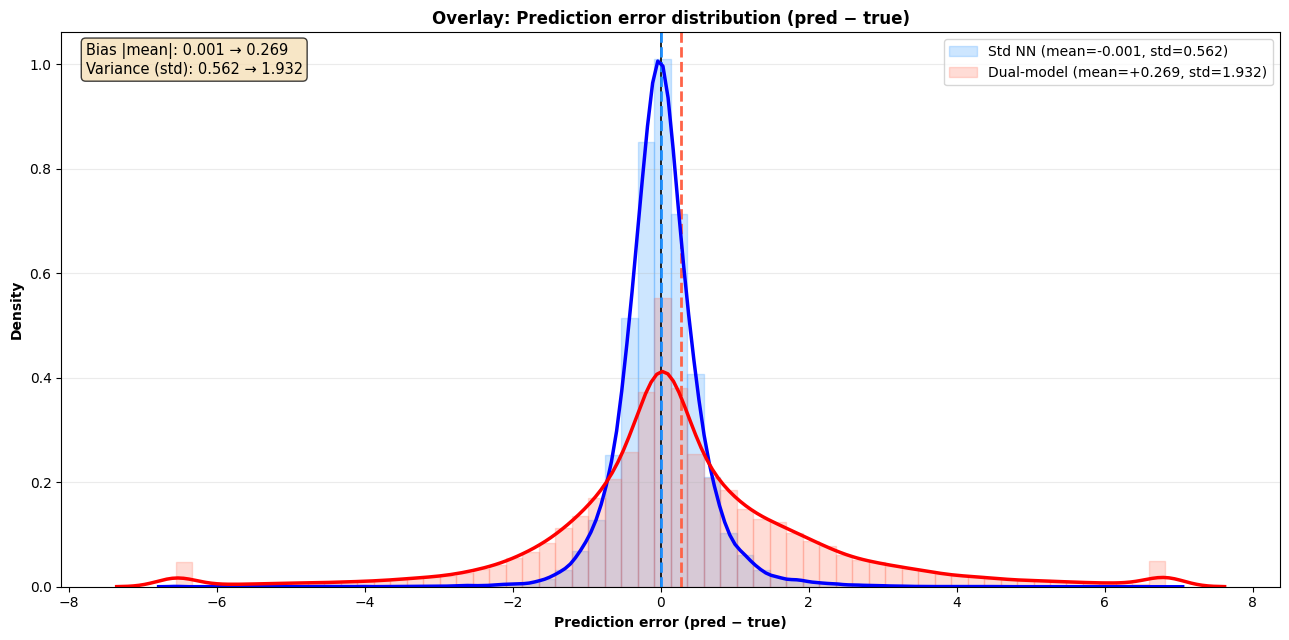

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("error_hist_csv/errors.csv")

err_s = df["err_std"].to_numpy(float)
err_d = df["err_dual"].to_numpy(float)
m = np.isfinite(err_s) & np.isfinite(err_d)
err_s, err_d = err_s[m], err_d[m]

lo, hi = np.percentile(np.r_[err_s, err_d], [0.5, 99.5])
err_s, err_d = np.clip(err_s, lo, hi), np.clip(err_d, lo, hi)
edges = np.histogram_bin_edges(np.r_[err_s, err_d], bins=60)

mu_s, sd_s = err_s.mean(), err_s.std(ddof=1)
mu_d, sd_d = err_d.mean(), err_d.std(ddof=1)

fig, ax = plt.subplots(figsize=(13, 6.5))

ax.hist(err_s, bins=edges, density=True, alpha=0.22,
        color="dodgerblue", edgecolor="dodgerblue",
        label=f"Std NN (mean={mu_s:+.3f}, std={sd_s:.3f})")
ax.hist(err_d, bins=edges, density=True, alpha=0.22,
        color="tomato", edgecolor="tomato",
        label=f"Dual-model (mean={mu_d:+.3f}, std={sd_d:.3f})")

ax.axvline(0, color="black", lw=1.2)
ax.axvline(mu_s, color="dodgerblue", ls="--", lw=2)
ax.axvline(mu_d, color="tomato", ls="--", lw=2)

try:
    import seaborn as sns
    sns.kdeplot(err_s, ax=ax, lw=2.5, bw_adjust=1.2, color="blue")
    sns.kdeplot(err_d, ax=ax, lw=2.5, bw_adjust=1.2, color="red")
except Exception:
    pass

ax.set_title("Overlay: Prediction error distribution (pred − true)", fontweight="bold")
ax.set_xlabel("Prediction error (pred − true)", fontweight="bold")
ax.set_ylabel("Density", fontweight="bold")
ax.grid(axis="y", alpha=0.25)

ax.text(
    0.02, 0.98,
    f"Bias |mean|: {abs(mu_s):.3f} → {abs(mu_d):.3f}\n"
    f"Variance (std): {sd_s:.3f} → {sd_d:.3f}",
    transform=ax.transAxes, va="top", fontsize=10.5,
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.75)
)

ax.legend()
plt.tight_layout()
plt.show()


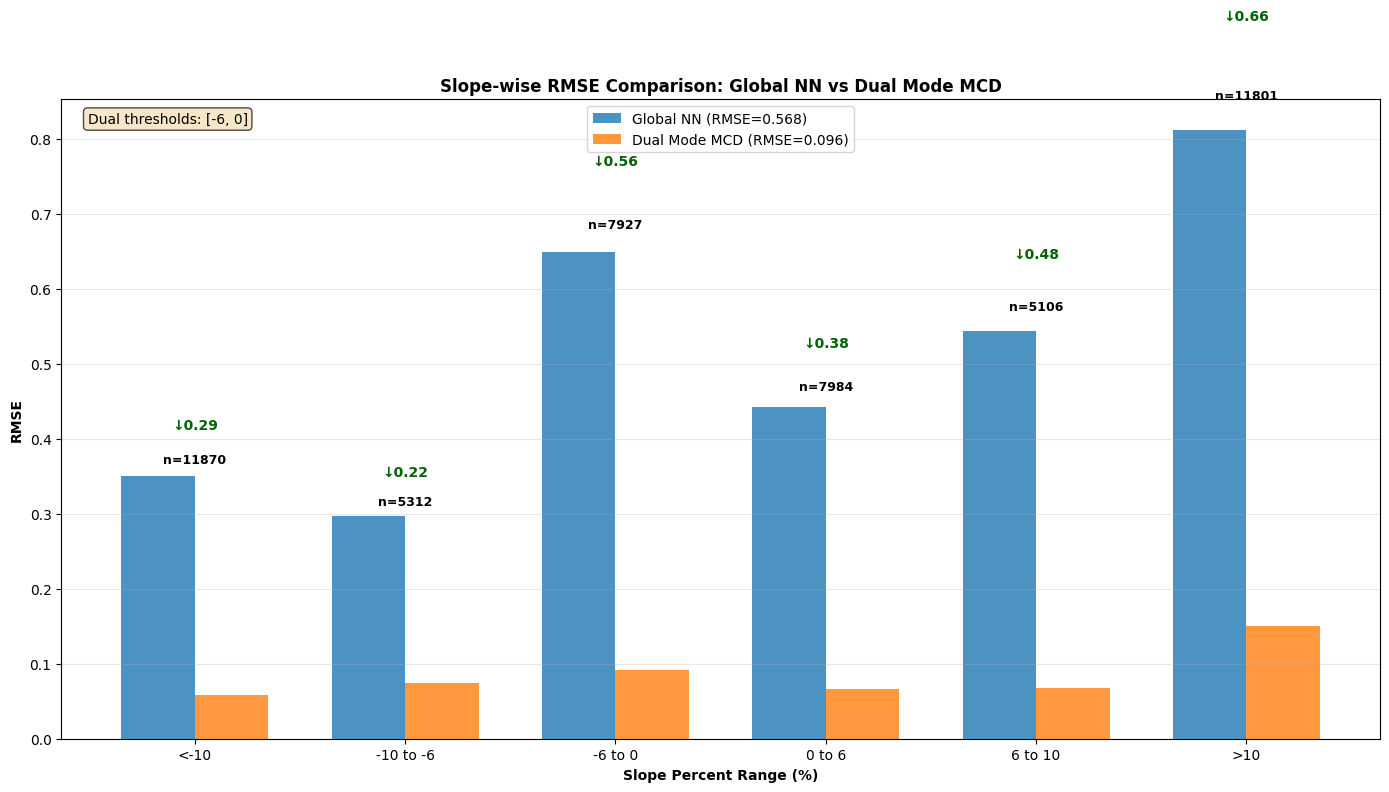

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

df = pd.read_csv("comparison_plots/plot_data_global_vs_dual_mode_mcd.csv")

y = df["y_true"].to_numpy()
g = df["global_pred"].to_numpy()
d = df["dual_mode_mcd_pred"].to_numpy()
s = df["slope_percent"].to_numpy()

g_rmse_all = df["global_rmse"].iloc[0]
d_rmse_all = df["dual_mode_mcd_rmse"].iloc[0]
t_lo, t_hi = df["threshold_low"].iloc[0], df["threshold_high"].iloc[0]

bins = [-np.inf, -10, -6, 0, 6, 10, np.inf]
labels = ['<-10', '-10 to -6', '-6 to 0', '0 to 6', '6 to 10', '>10']

g_rmse, d_rmse, n = [], [], []

for i in range(len(bins) - 1):
    m = (s >= bins[i]) & (s < bins[i+1])
    if m.sum() > 1:
        g_rmse.append(np.sqrt(mean_squared_error(y[m], g[m])))
        d_rmse.append(np.sqrt(mean_squared_error(y[m], d[m])))
        n.append(m.sum())
    else:
        g_rmse.append(np.nan); d_rmse.append(np.nan); n.append(0)

idx = [i for i in range(len(n)) if n[i] > 0]
x = np.arange(len(idx))
w = 0.35

plt.figure(figsize=(14, 8))
bg = plt.bar(x - w/2, [g_rmse[i] for i in idx], w,
             label=f"Global NN (RMSE={g_rmse_all:.3f})", alpha=0.8)
bd = plt.bar(x + w/2, [d_rmse[i] for i in idx], w,
             label=f"Dual Mode MCD (RMSE={d_rmse_all:.3f})", alpha=0.8)

for i, k in enumerate(idx):
    mx = max(g_rmse[k], d_rmse[k])
    plt.text(x[i], mx*1.05, f"n={n[k]}", ha="center", fontsize=9, fontweight="bold")

    diff = g_rmse[k] - d_rmse[k]
    if abs(diff) > 0.01:
        plt.text(x[i], mx*1.18,
                 f"{'↓' if diff>0 else '↑'}{abs(diff):.2f}",
                 ha="center", fontweight="bold",
                 color="darkgreen" if diff>0 else "darkred")

plt.text(0.02, 0.98,
         f"Dual thresholds: [{t_lo}, {t_hi}]",
         transform=plt.gca().transAxes,
         va="top", fontsize=10,
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7))

plt.xticks(x, [labels[i] for i in idx])
plt.xlabel("Slope Percent Range (%)", fontweight="bold")
plt.ylabel("RMSE", fontweight="bold")
plt.title("Slope-wise RMSE Comparison: Global NN vs Dual Mode MCD",
          fontweight="bold")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
